<a href="https://colab.research.google.com/github/navapro/stock-and-crypto-prediction/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection and Processing

In [ ]:
!pip install numpy pandas sklearn ta matplotlib xgboost
!pip install --upgrade pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mixture
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [ ]:
start_date = "2017-01-01"
end_date = "2022-11-01"
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()

In [ ]:
# add RSI
df_fe = df.copy()
rsi = RSIIndicator(close = df_fe["Close"], window = 14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"]/df_fe["RSI"].shift(1)

In [ ]:
# add moving averages
df_fe["MA_12"] = df_fe["Close"].rolling(window = 12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window = 21).mean()

In [ ]:
# add day of week
df_fe["DOW"] = df_fe.index.dayofweek

In [ ]:
# add rolling cumulitive returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window = 30).sum()

In [ ]:
# add rolling cumulitive returns
df_fe["Avg_Range"] = df_fe["Range"].rolling(window = 30).mean()

In [ ]:
# add time intevals
time_steps = [1, 2]
time_features = ["Returns", "Range", "RSI_Ret"]

for time_step in time_steps:
  for time_feature in time_features:
    df_fe[f"{time_feature}_T{time_step}"] = df_fe[time_feature].shift(time_step)

In [ ]:
df_fs  = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()

In [ ]:
df_fs.dropna(inplace = True)
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()

In [ ]:
df = df_fs.copy()
df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634
2017-02-03,0.021676,0.020079,0.026005,1029.910034,0.380309,0.017899,0.024861,0.032145,68.695922,1.035435,...,915.335333,4,-0.079792,0.054832,0.023030,0.030816,1.051268,0.019188,0.018926,1.048237
2017-02-04,0.019645,0.011636,0.006314,1042.900024,-0.229603,0.012613,0.030281,0.045785,70.298572,1.023330,...,926.025239,5,0.055230,0.045565,0.017899,0.024861,1.035435,0.023030,0.030816,1.051268


# Supervized machine learning - Initial Model


In [ ]:
import warnings
warnings.simplefilter(action = "ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
from sklearn.metrics import plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

In [ ]:
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0
df["TARGET"].fillna(0, inplace = True)

In [ ]:
df_tts = df.copy()
# df_tts = df_tts[["Returns", "Range", "RSI", "RSI_Ret", "Returns_T1", "RSI_Ret_T1", "TARGET"]]

X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

Build the initial model

In [ ]:

is_binary = True
is_optimise_for_precision = True


if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"


In [ ]:
# Train model
# ne: 25, lr: 0.05 md: 2 gm: 1.5
ne = 80
lr = 0.01
md = 2
gm = 3

classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.fit(
    X_train,
    y_train,
    eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(eval_metric='aucpr', gamma=3, learning_rate=0.01, max_depth=2,
              n_estimators=80, random_state=1, subsample=0.8,
              use_label_encoder=False)

Make prediction

In [ ]:
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Preds Probabilities Training Data: 
 [[0.6271062  0.3728938 ]
 [0.6257607  0.3742393 ]
 [0.6038352  0.39616475]]


In [ ]:
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [1. 0. 1. 1. 0. 1. 0. 0. 1. 1.]
Preds Probabilities Training Data: 
 [[0.47672278 0.5232772 ]
 [0.56258535 0.43741462]
 [0.47028917 0.5297108 ]]


In [ ]:
cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats= 1, random_state = 1)

In [ ]:
train_results = cross_val_score(classifier, X_train, y_train, scoring = scoring, cv = cv, n_jobs = 1)

Evaluate Results

In [ ]:
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

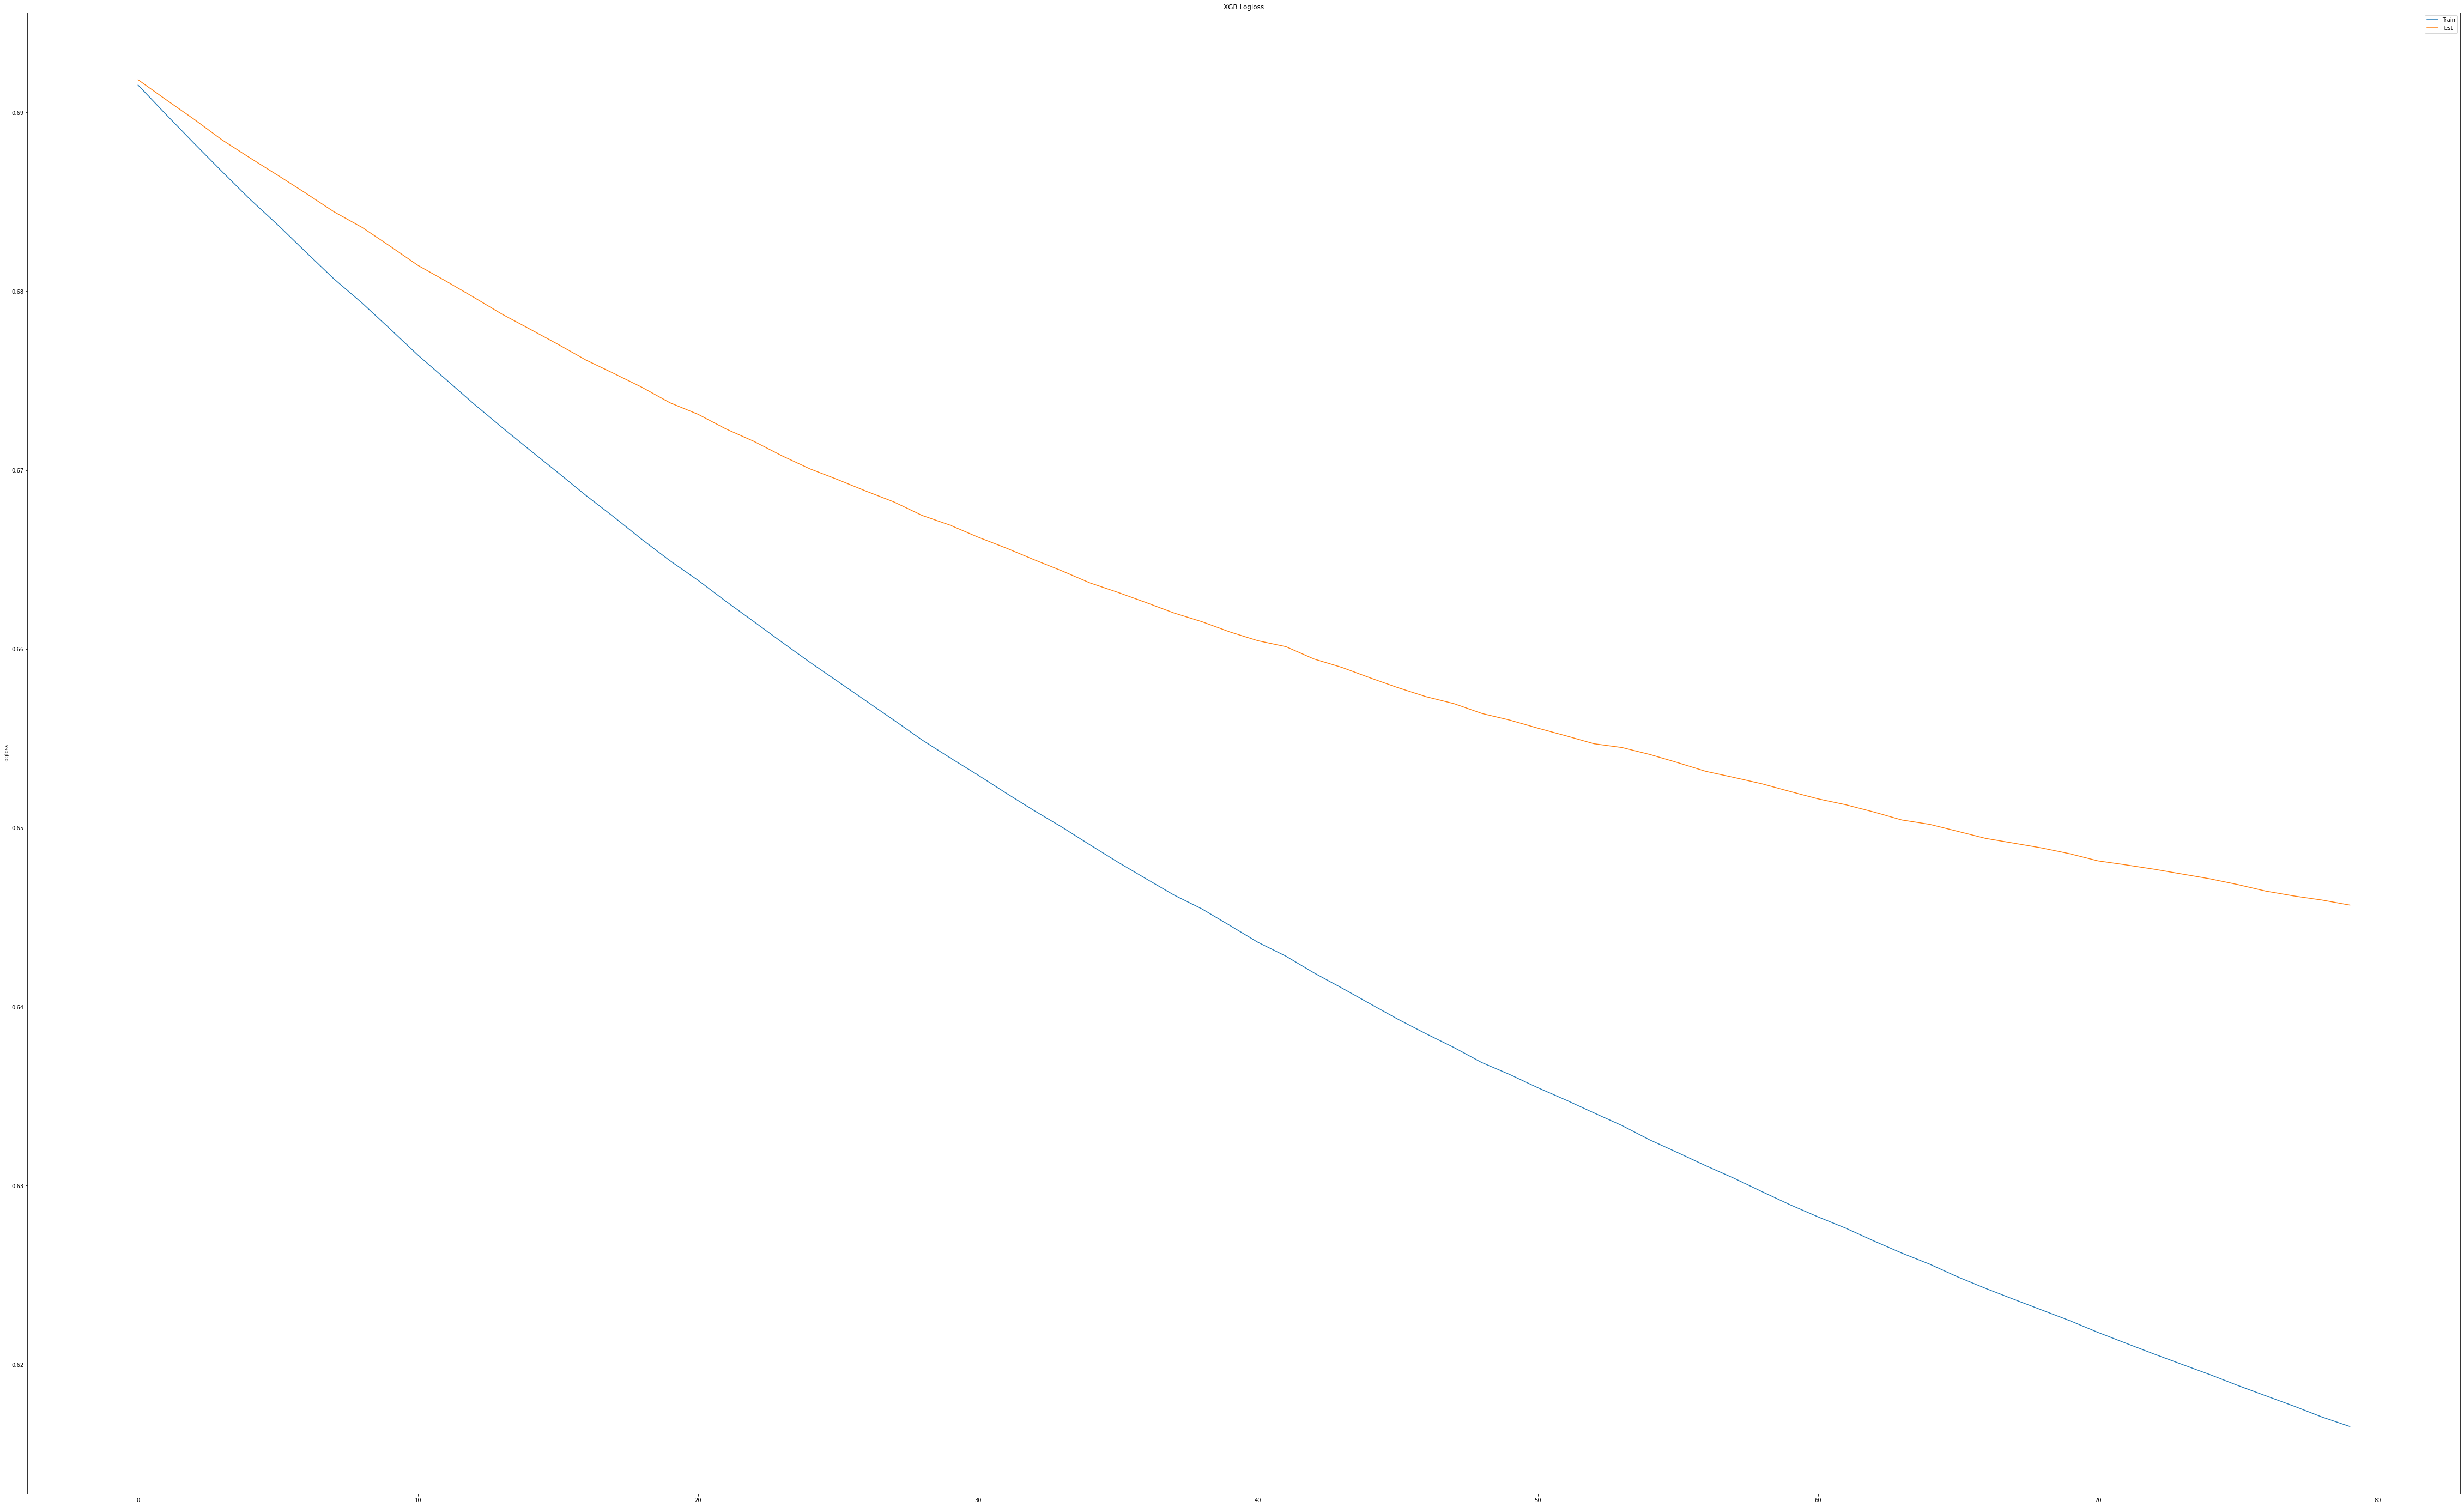

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

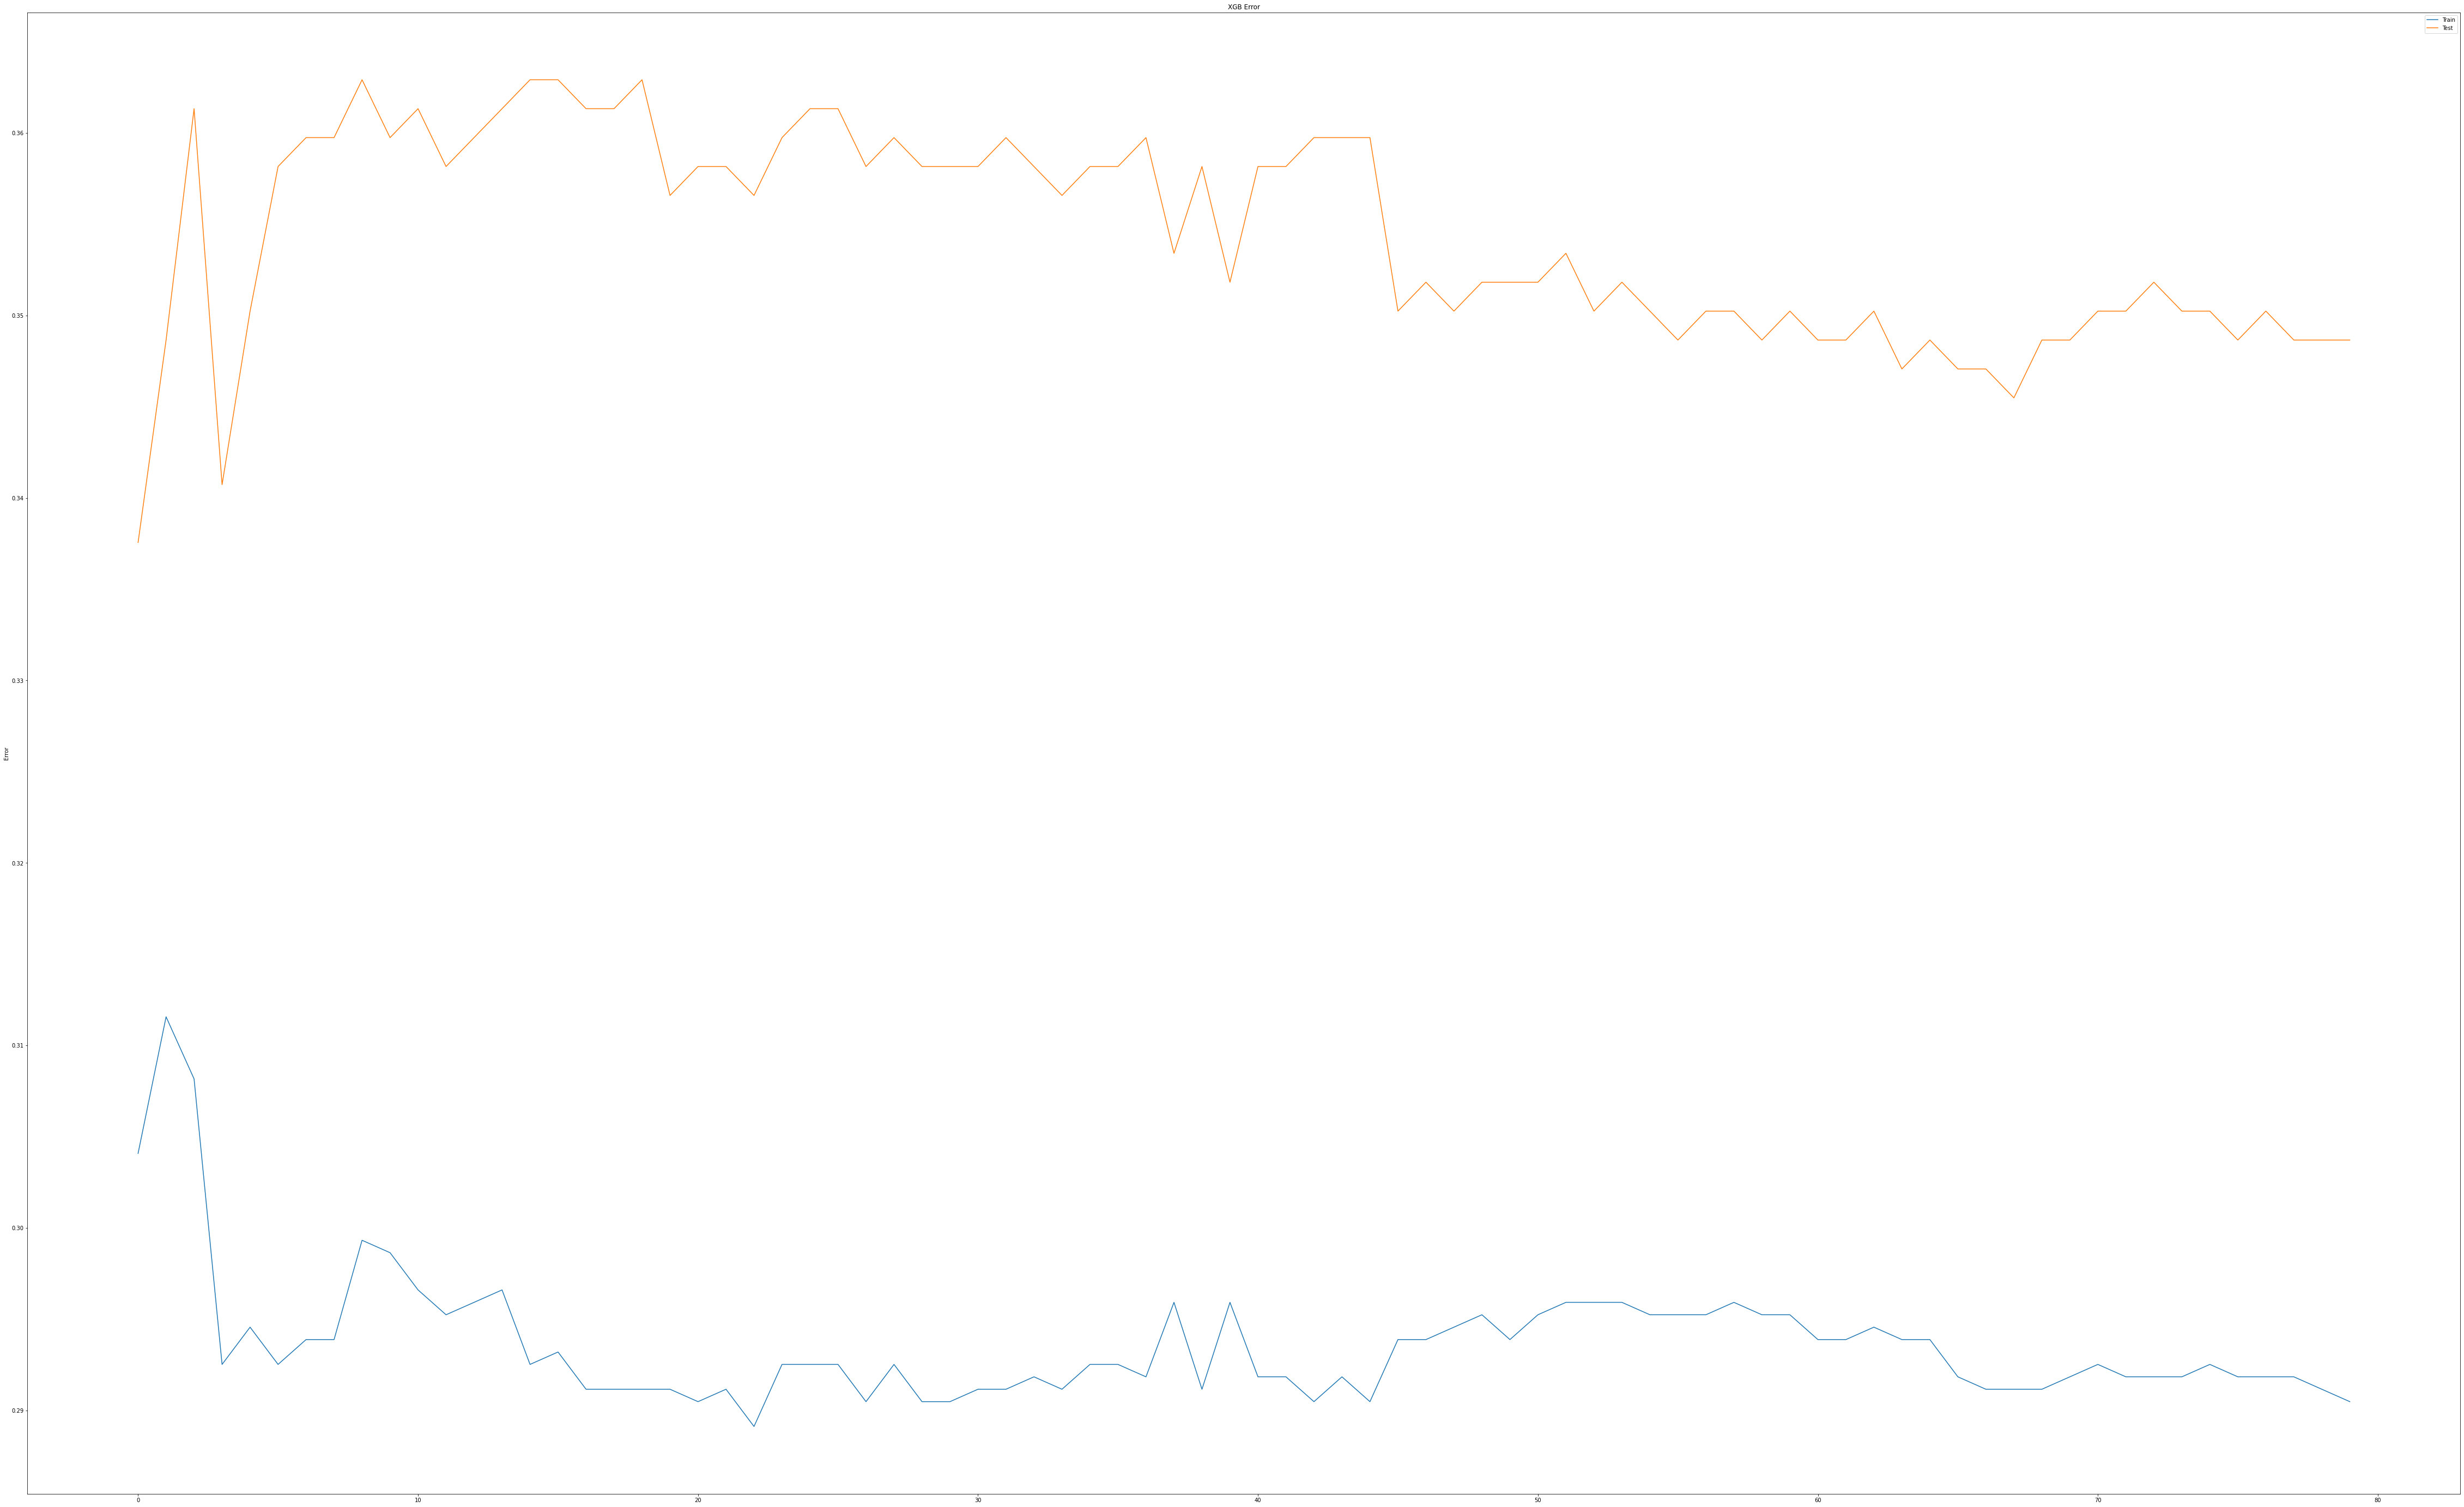

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

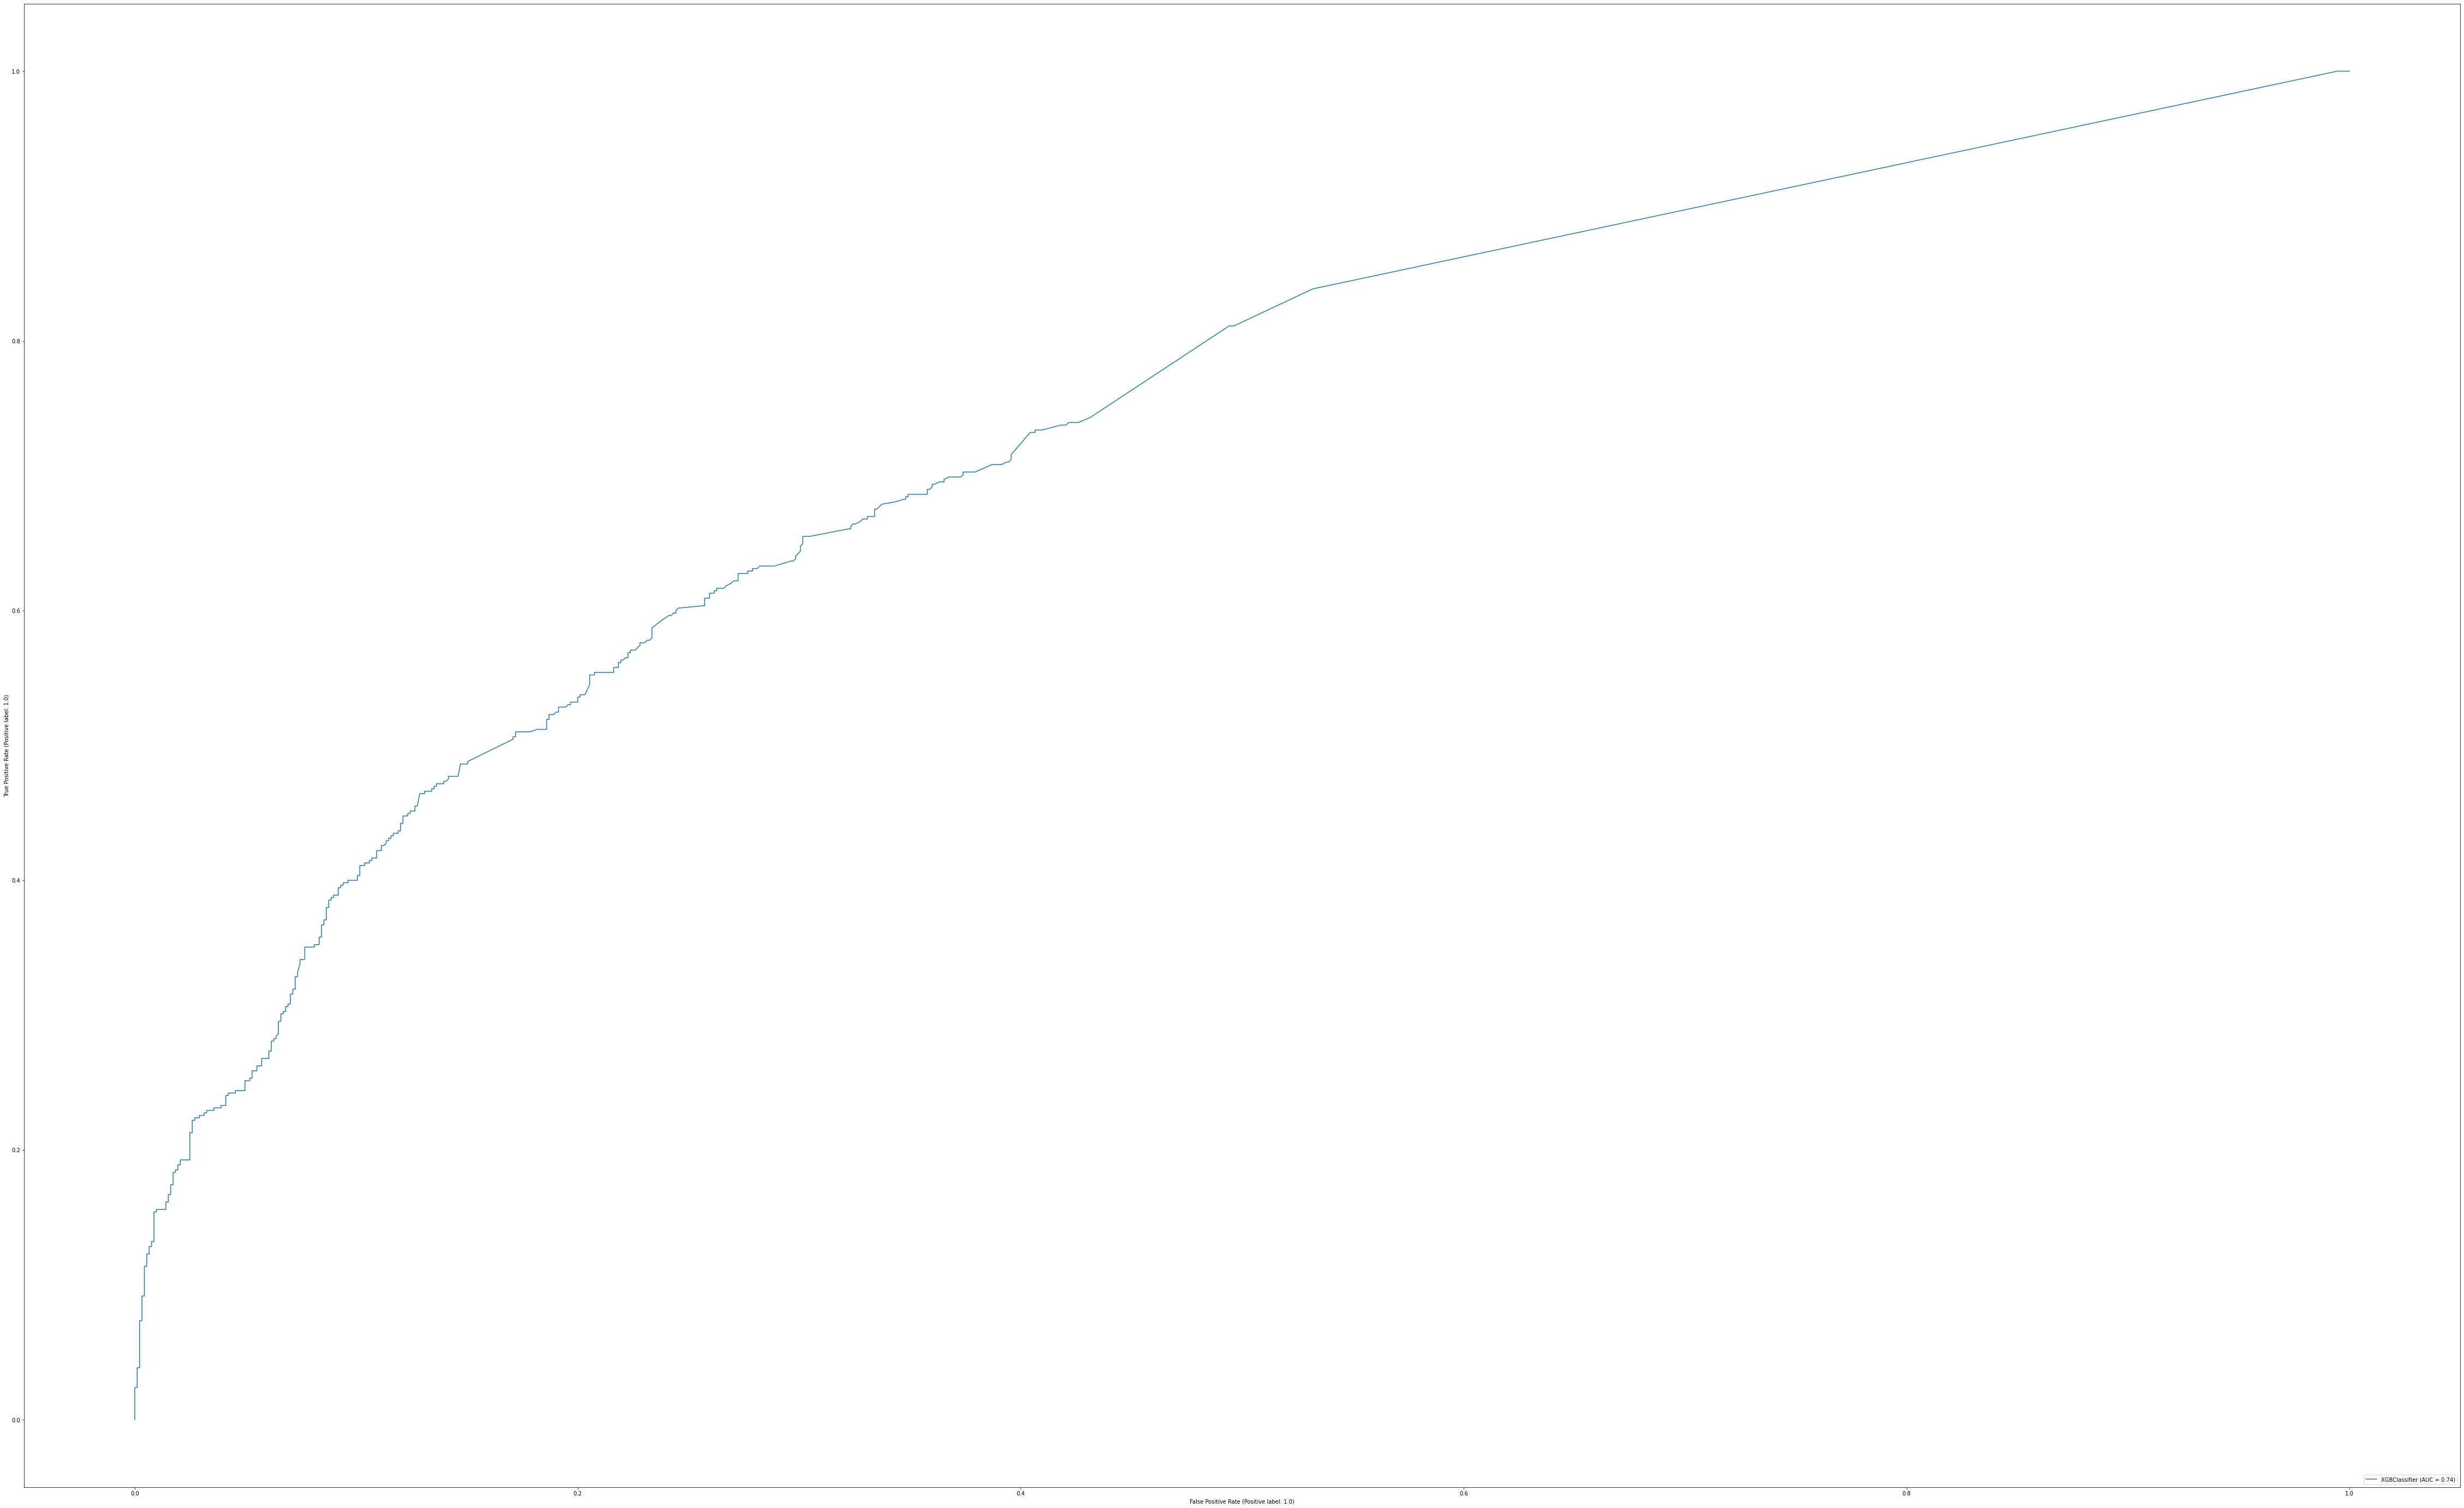

In [ ]:
plot_roc_curve(classifier, X_train, y_train)

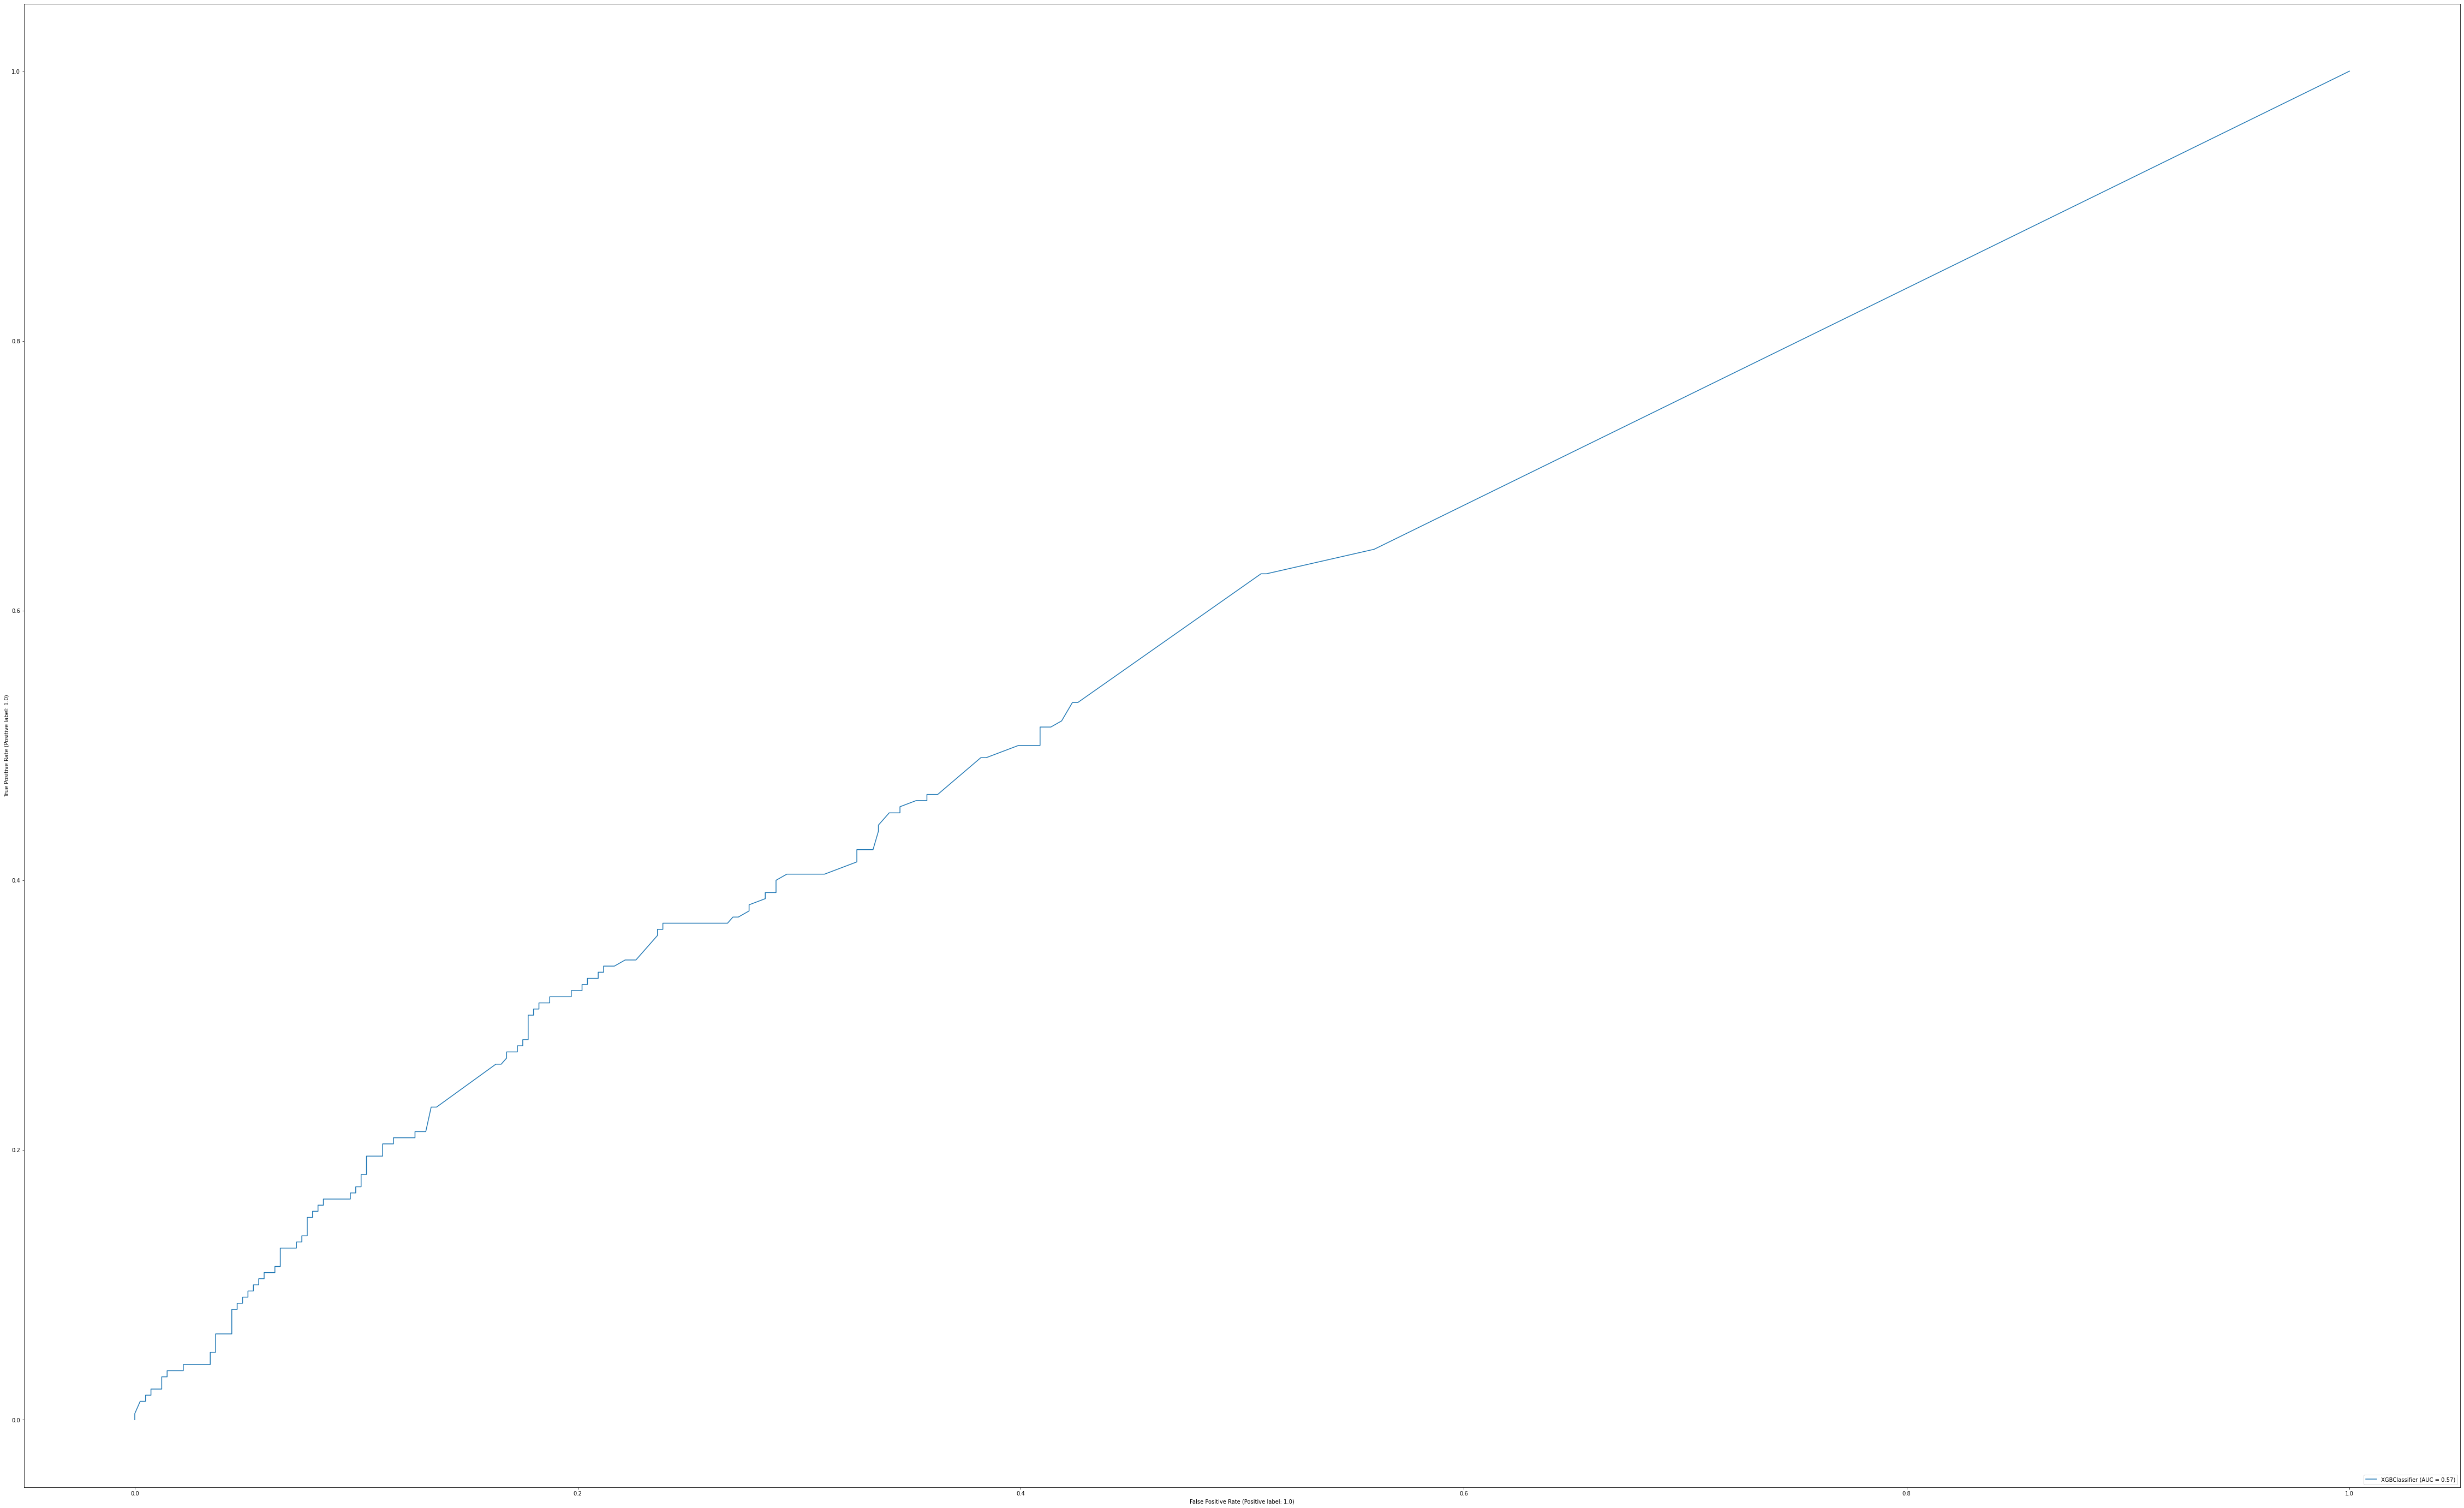

In [ ]:
plot_roc_curve(classifier, X_test, y_test)

In [ ]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

In [ ]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.66
Std Dev K-Fold 0.04
Precision Score 0 0.706
Precision Score 1 0.727
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.64
Std Dev K-Fold 0.18
Precision Score 0 0.664
Precision Score 1 0.5



In [ ]:
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.71      0.92      0.80       925
         1.0       0.73      0.35      0.47       545

    accuracy                           0.71      1470
   macro avg       0.72      0.64      0.63      1470
weighted avg       0.71      0.71      0.68      1470



In [ ]:
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.66      0.94      0.78       411
         1.0       0.50      0.11      0.18       220

    accuracy                           0.65       631
   macro avg       0.58      0.53      0.48       631
weighted avg       0.61      0.65      0.57       631



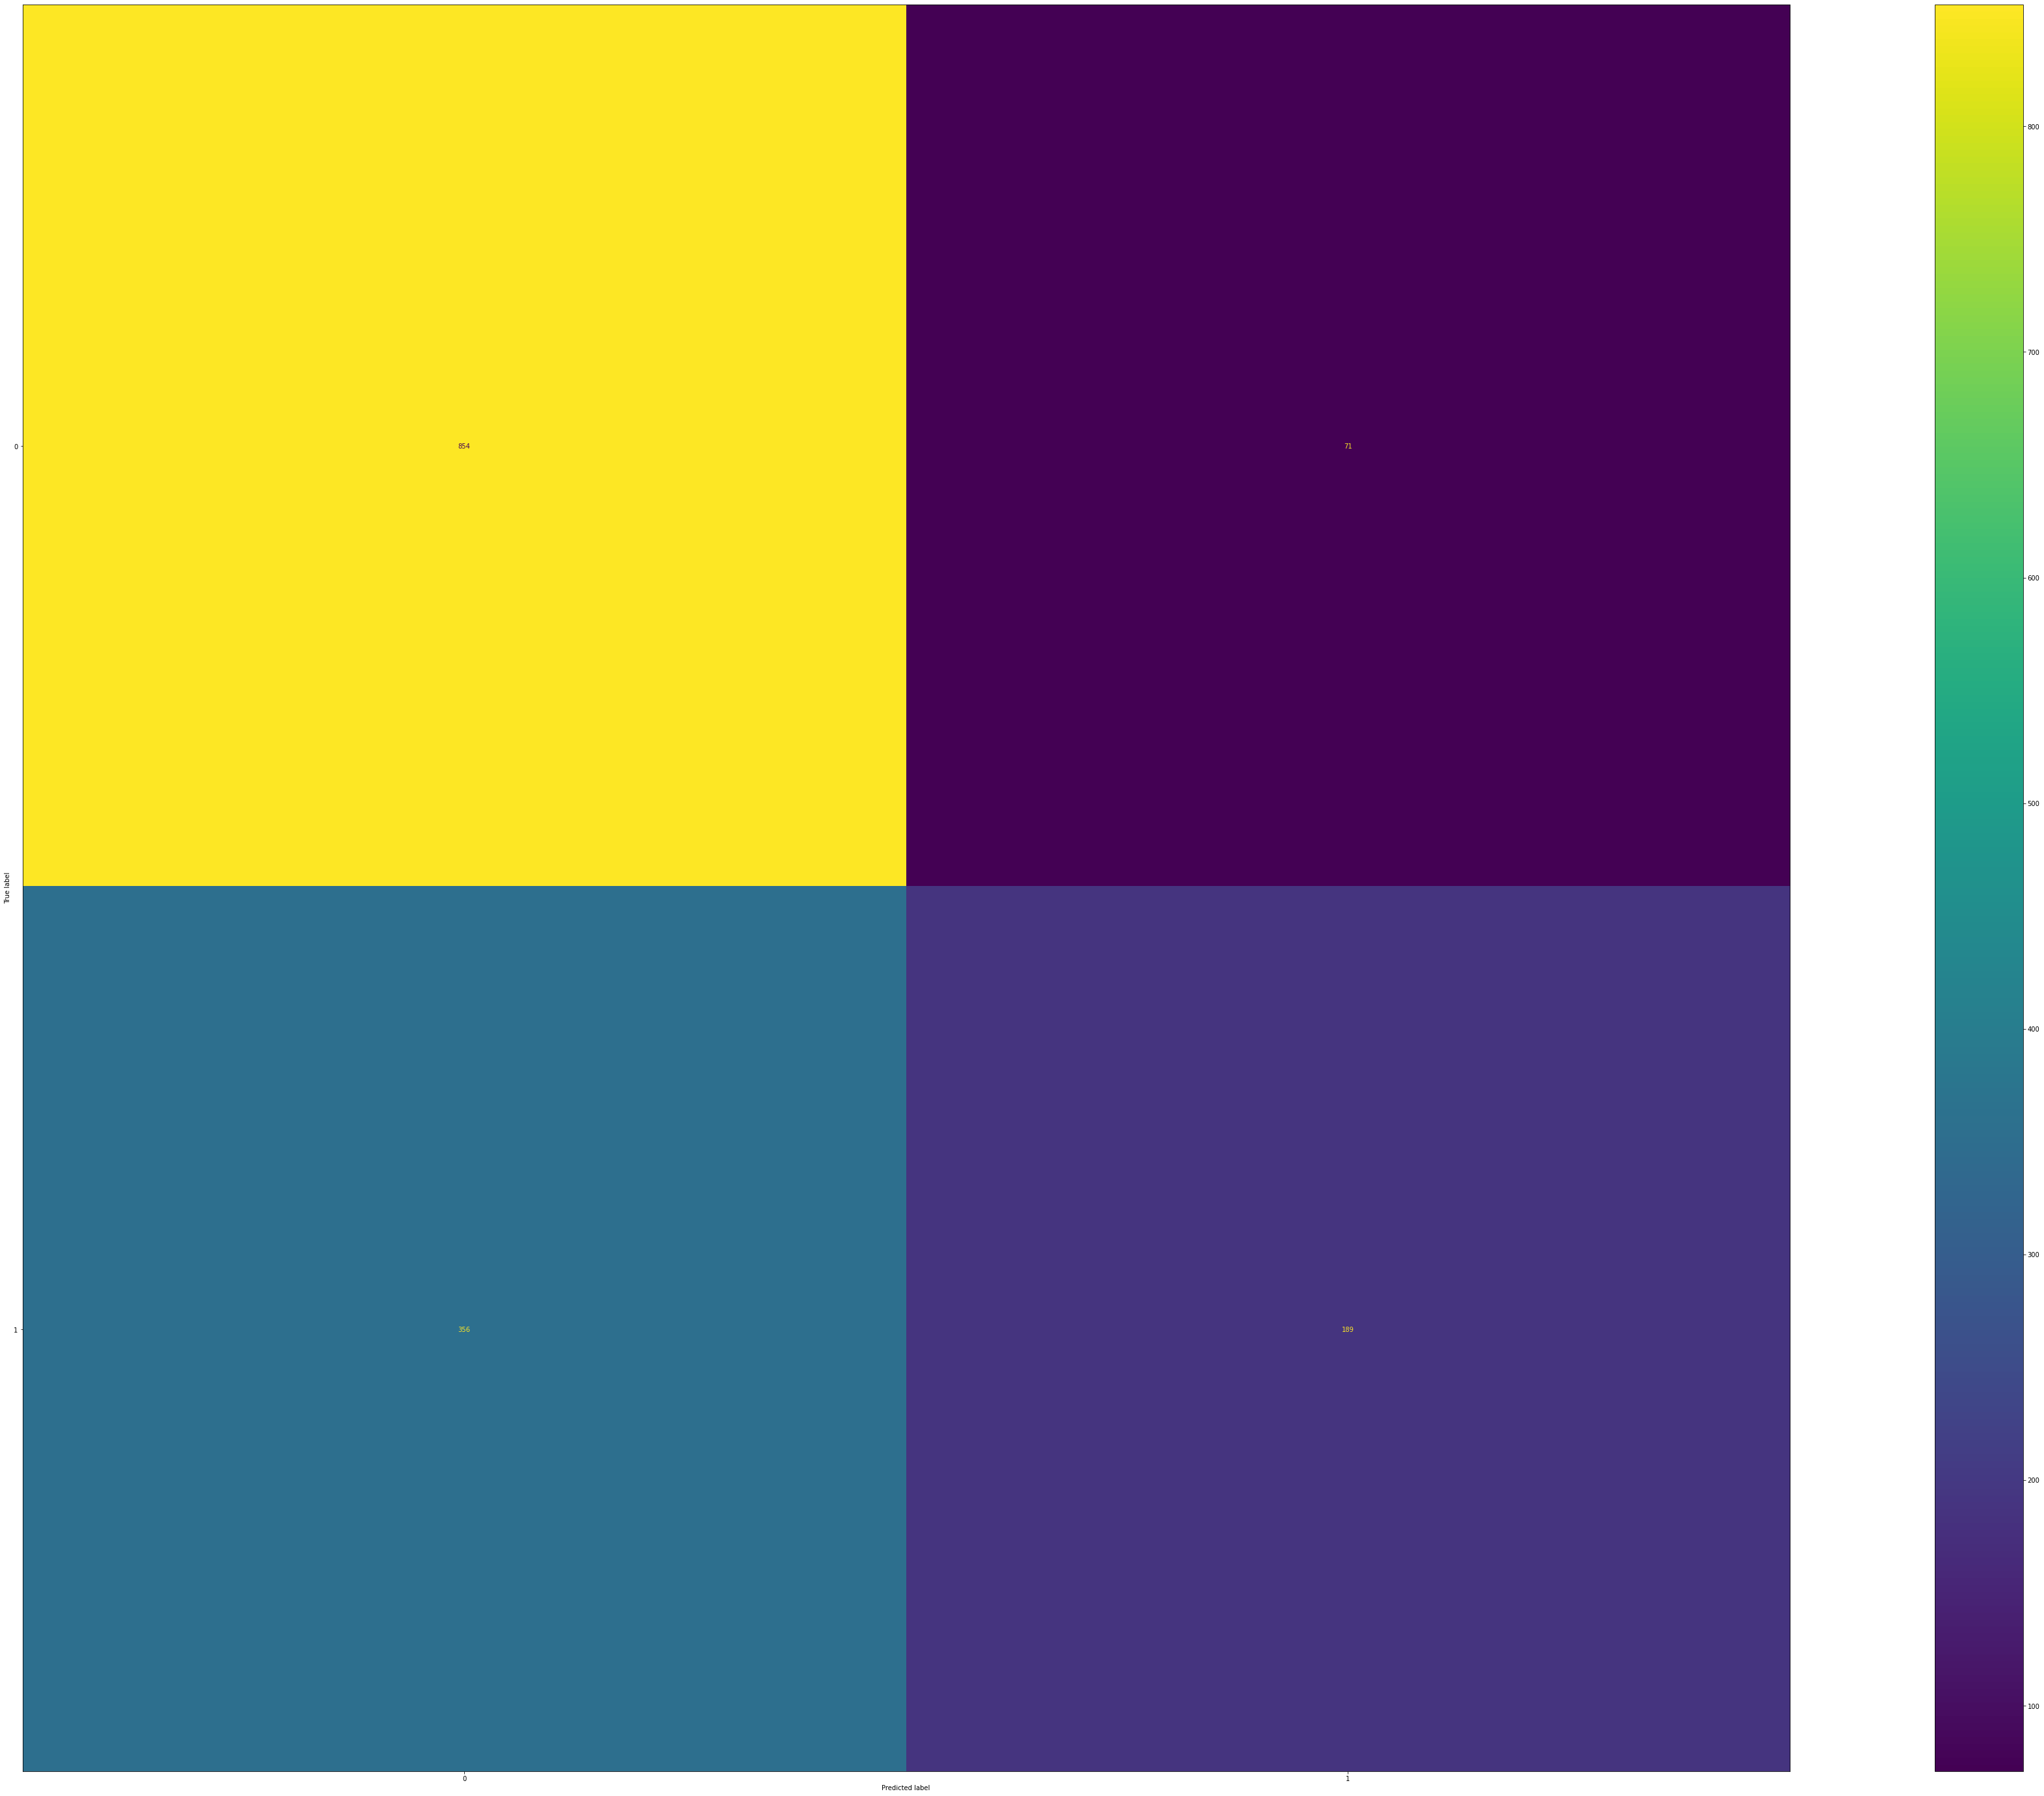

In [ ]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

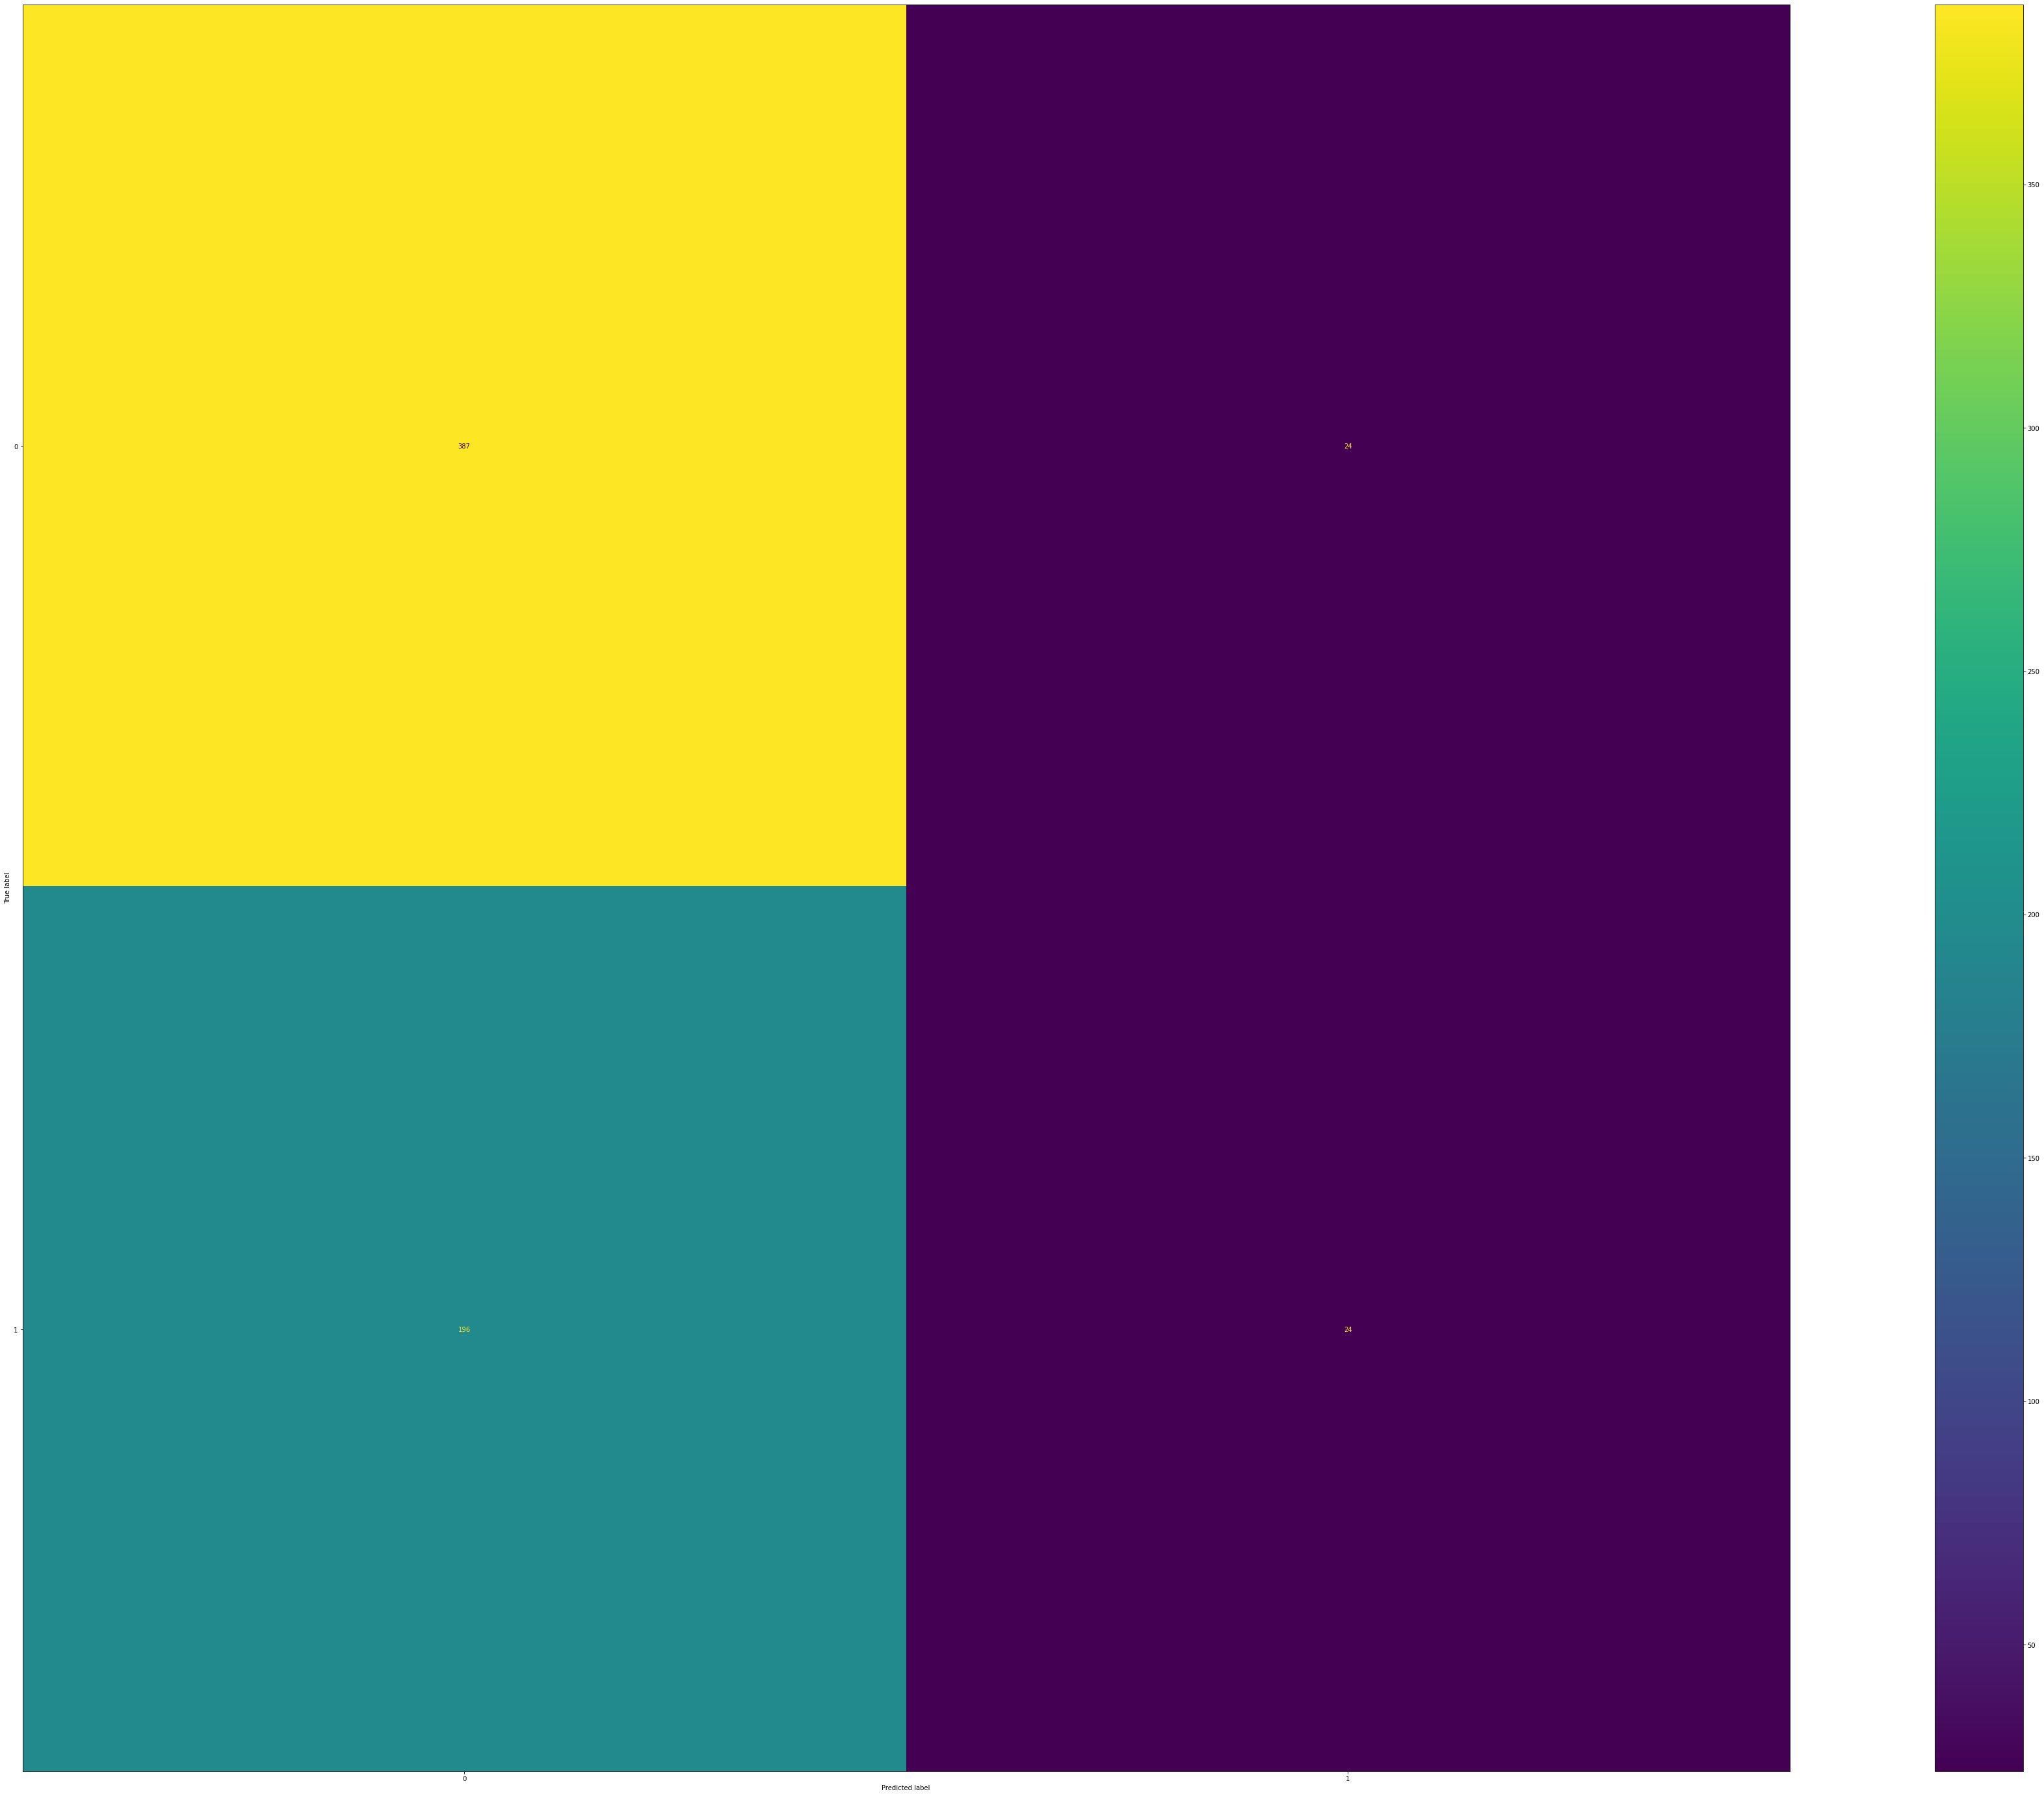

In [ ]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

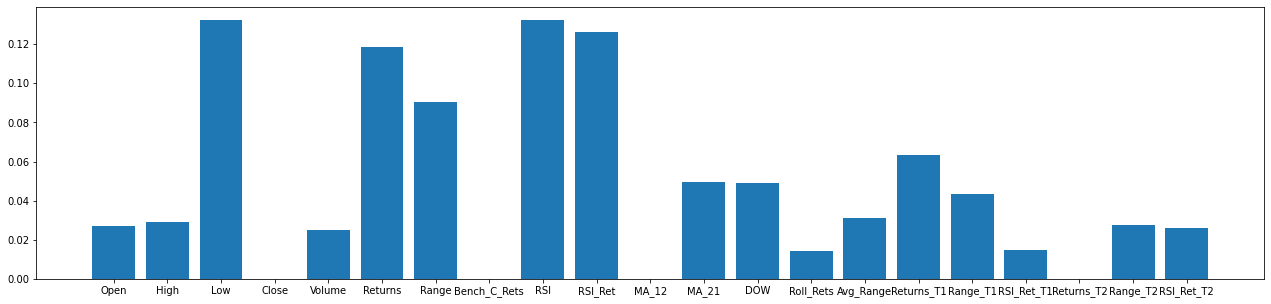

In [ ]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

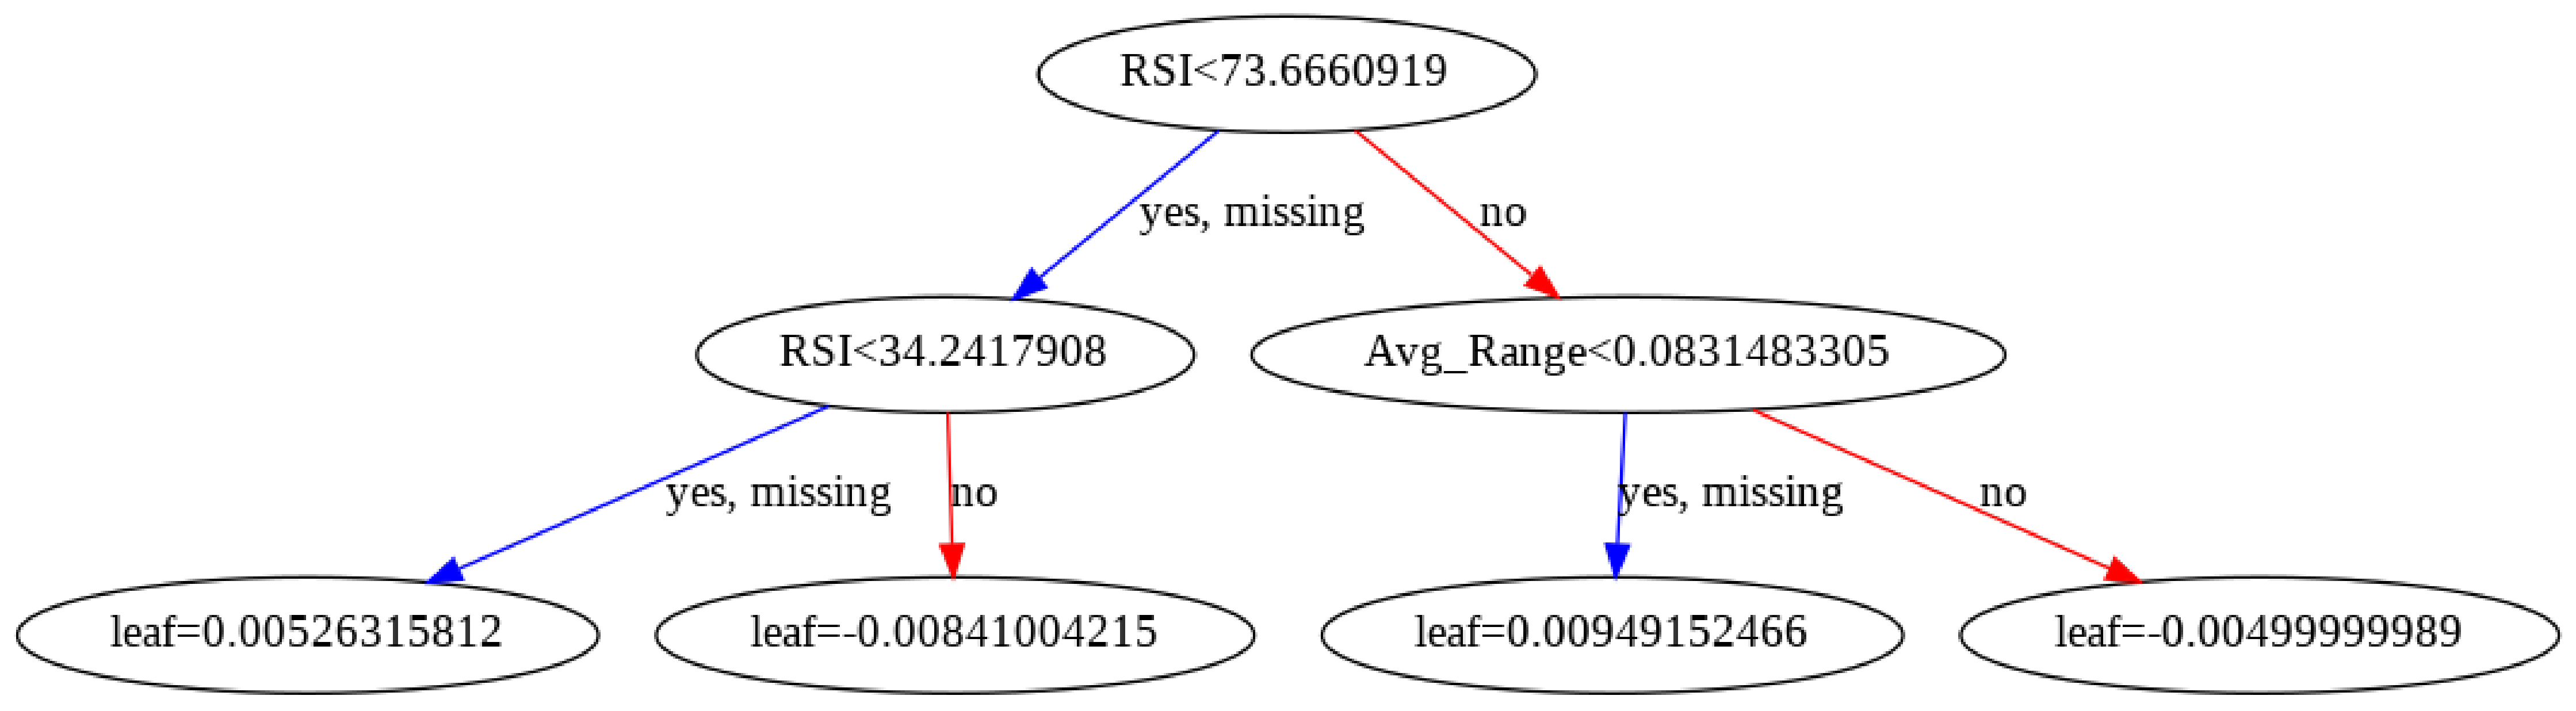

In [ ]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)